In [94]:
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
import numpy as np
import matplotlib.pyplot as plt

In [95]:
m1 = fits.open('lcFiles/ch2_xsm_20210923_v1_level2.lc')
m2 = fits.open('lcFiles/ch2_xsm_20210924_v1_level2.lc')
m3 = fits.open('lcFiles/ch2_xsm_20210927_v1_level2.lc')
m4 = fits.open('lcFiles/ch2_xsm_20210928_v1_level2.lc')
m5 = fits.open('lcFiles/ch2_xsm_20210929_v1_level2.lc')
m1.info()
m2.info()
m3.info()
m4.info()
m5.info()

data = (m1, m2, m3, m4, m5)

Filename: lcFiles/ch2_xsm_20210923_v1_level2.lc
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   ()      
  1  RATE          1 BinTableHDU     64   84280R x 4C   [D, E, E, E]   
Filename: lcFiles/ch2_xsm_20210924_v1_level2.lc
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   ()      
  1  RATE          1 BinTableHDU     64   83434R x 4C   [D, E, E, E]   
Filename: lcFiles/ch2_xsm_20210927_v1_level2.lc
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   ()      
  1  RATE          1 BinTableHDU     64   83613R x 4C   [D, E, E, E]   
Filename: lcFiles/ch2_xsm_20210928_v1_level2.lc
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   ()      
  1  RATE          1 BinTableHDU     64   84991R x 4C   [D, E, E, E]   
Filename: lcFiles/ch2_xsm_20210929_v1_level2.lc
No.    Name      Ver

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   20 / width of table in bytes                        
NAXIS2  =                84280 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    4 / number of fields in each row                   
TTYPE1  = 'TIME    '           / label for field   1                            
TFORM1  = 'D       '           / data format of field: 8-byte DOUBLE            
TTYPE2  = 'RATE    '           / label for field   2                            
TFORM2  = 'E       '           / data format of field: 4-byte REAL              
TTYPE3  = 'ERROR   '        

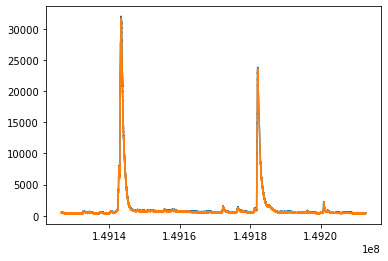

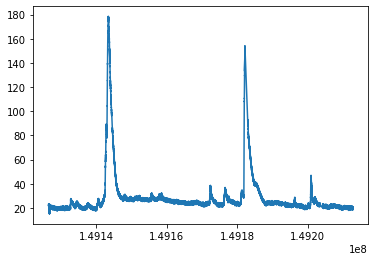

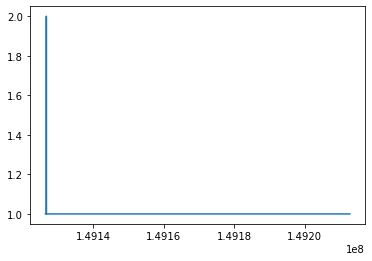

In [96]:
# Testing Block

display(m1[1].header)

plt.plot(m1[1].data['TIME'], m1[1].data['RATE'] + m1[1].data['ERROR'])
plt.plot(m1[1].data['TIME'], m1[1].data['RATE'] - m1[1].data['ERROR'])
plt.show()
plt.plot(m1[1].data['TIME'], m1[1].data['ERROR'])
plt.show()
plt.plot(m1[1].data['TIME'], m1[1].data['FRACEXP'])
plt.show()

0.15241888603354986

-0.004163841115290411

0.0016439974476568661

-0.0008302990608010071

0.010553093069365964

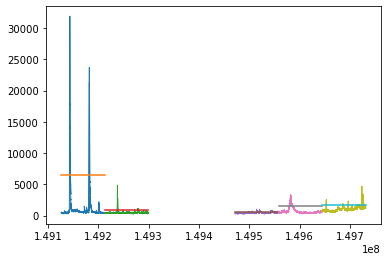

In [97]:
def flarestart(rate, u, std):
    starts = []
    wasAboveThreshold = False
    urate = sum(ratedata)/len(ratedata)
    stdrate = ratedata.std()
    threshold = urate + 4.7*stdrate
    skips = 0
    for i in range(len(ratedata)):
        if ratedata[i] > 75:
            starts.append(i)
    return starts

for mi in data:
    rate = mi[1].data['RATE']
    time = mi[1].data['TIME']
    raterate = np.zeros(len(rate))
    for i in range(1, len(rate)):
        raterate[i] = ((rate[i]-rate[i-1])/(time[i]-time[i-1]))
    u = rate.mean()
    std = rate.std()
    
    uDynamic = [rate[0]]
    
    for i in range(1, len(rate)):
        uDynamic.append((uDynamic[i-1]*i + rate[i])/(i+1))
    
    #starts = flarestart(raterate)
    #for i in range(len(starts)):
    #    plt.plot([time[starts[i]], time[starts[i]]], [0, max(max(rate), 5000)])
    
    display(raterate.mean())
    plt.plot(time, rate, linewidth=1)
    plt.plot([min(time), max(time)], [u+1.8*std, u+1.8*std])
    #plt.ylim(0, max(max(mi[1].data['RATE']), 5000))
plt.show()

In [98]:
# Here we try something: averaging

display(m1[1].data.shape)

(84280,)

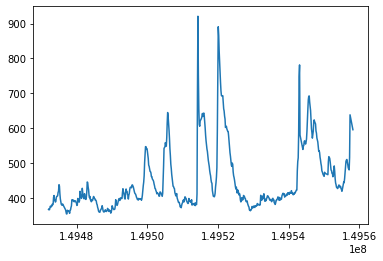

In [99]:
rateavg = []
timeavg = []
avg = 128
filedata = m3[1]
for i in range(int(np.floor(filedata.data.shape[0]/avg))):
    rateavg.append(sum(filedata.data['RATE'][i*avg:i*avg + avg-1])/avg)
    timeavg.append(filedata.data['TIME'][i*avg])
    
plt.plot(timeavg, rateavg)
plt.show()

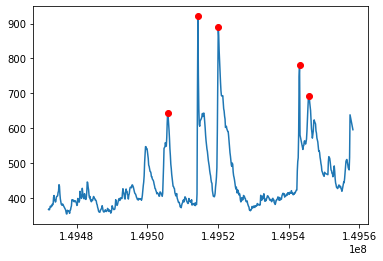

In [100]:
# We'll try here to detect peaks

def detectPeaks(rateData):
    # Return the indices at which the rateData achieves peaks
    peaks = []
    
    # Using the mean as a base value didn't work too well, so we set the base value to (mean + n*sigma) 
    # where n is some number and sigma is the standard deviation
    # Very scuffed method, I know, thanks.
    u = np.mean(rateData)
    std = np.std(rateData)
    
    # We don't want every peak, only the prominent ones
    # I refuse to define 'prominent' :P
    
    delta = 15
    for i in range(delta, len(rateData)-delta):
        isPeak = False
        for j in range(i-delta, i+delta):
            if rateData[j] > rateData[i]:
                break
            elif j == i+delta-1:
                if rateData[i] > u+1.8*std:
                    isPeak = True
        if isPeak:
            peaks.append(i)
    
    return peaks
        
        
peakIndices = detectPeaks(rateavg)
timepeaks = [timeavg[i] for i in peakIndices]
ratepeaks = [rateavg[i] for i in peakIndices]
    
plt.plot(timeavg, rateavg)
plt.plot(timepeaks, ratepeaks, 'ro')
plt.show()

In [91]:
# Testing Block 2.0

# We want to somehow detect clear peaks
# The algorithm developed in this block is an attempt at that

In [ ]:
# Here we attempt to detect the start times of solar flares